# Introduction to drEye

*drEye* is a package that implements various approaches to design stimuli for sensory receptors. The main focus of the package is geared towards designing color stimuli for any animal under investigation, where the photoreceptor spectral sensitivities are known. The hardware-agnostic approach incorporates photoreceptor models within the framework of the principle of univariance. This enables experimenters to identify the most effective way to combine multiple light sources to create desired distributions of light, and thus easily construct relevant stimuli for mapping the color space of an organism. The methods support broad applications in color vision science and provide a framework for uniform stimulus designs across experimental systems. Many of the methods described can be used more generally to design stimuli for other sensory organs or used more broadly where a set of linear filters define the input to a system. In this introductory tutorial, we will cover some of the basics of the *drEye* API using basic examples from color vision science.

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns

import dreye

## Defining receptor filters and sources of excitations

The main approach of our method relies on the knowledge of the receptor filters - i.e. the spectral sensitivities of photoreceptors - and the measured sources of excitations - e.g. the spectral distribution of selected LEDs. In this example, we will assume we have an animal that has two photoreceptor types with different sensitivities. Our stimulation system consists of three LEDs that we can vary independently between 0 and 0.1 photon flux.  

First, we will define the wavelength range that is relevant and use the opsin template from the Govardoskii et al., 2000 paper to define the spectral sensitivity filters. We also have other templates available to define filters (see API reference for details). All template functions return `numpy.ndarray` objects.

In [2]:
# wavelength range
wls = np.arange(300, 700, 1)
# peaks of the sensitivities
peaks = np.array([420, 535])
# opsin template
# an empty axis is added to the peaks so that the array object has dimension (opsin_type x wavelengths)
filters = dreye.govardovskii2000_template(wls, peaks[:, None])

Next, we define our LEDs. Here, we will use a simple Gaussian distribution to define our LEDs, but any spectral distribution is valid as long as it is formated as a `numpy.ndarray` object with dimension (led_type x wavelengths). Importantly, we normalize the array by the estimated integral so that the array is in units $1/nm$.

In [3]:
led_peaks = np.array([410, 480, 550])
sources = norm.pdf(wls, loc=led_peaks[:, None], scale=20)
sources = sources / dreye.integral(sources, wls, axis=-1, keepdims=True)

## The `ReceptorEstimator` object

The main object used in *drEye* is the `ReceptorEstimator` object. This object stores the filters and sources, as well as other information and contains all the necessary methods to assess the gamut of the system and fit arbitrary spectral sensitivities. 
To initial this object, we need to supply the filters and wavelength domain array. We may also supply the LED spectra and the intensity bounds, or register them separately using the `register_system` method (see API reference for details). 

In [4]:
est = dreye.ReceptorEstimator(
    # filters array
    filters, 
    # wavelength array
    domain=wls, 
    # labels for each photoreceptor type (optional)
    labels=['S', 'L'], 
    # LED array, optional
    sources=sources, 
    # lower bound of each LED, optional
    lb=np.zeros(3), 
    # upper bound for each LED, optional - if None, then the upper bound is infinity
    ub=np.ones(3) * 0.1, 
    # labels for sources, optional
    sources_labels=['V', 'C', 'G']
)

### Plotting the sensitivity filters and LED sources

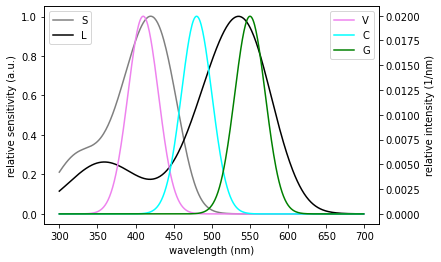

In [5]:
filters_colors = ['gray', 'black']
sources_colors = ['violet', 'cyan', 'green']

ax1 = est.filter_plot(colors=filters_colors)
ax2 = plt.twinx(ax1)
est.sources_plot(colors=sources_colors, ax=ax2)

ax1.set_xlabel('wavelength (nm)')
ax1.set_ylabel('relative sensitivity (a.u.)')
ax2.set_ylabel('relative intensity (1/nm)')

ax1.legend(loc=2)
ax2.legend(loc=1)

### Plotting the gamut

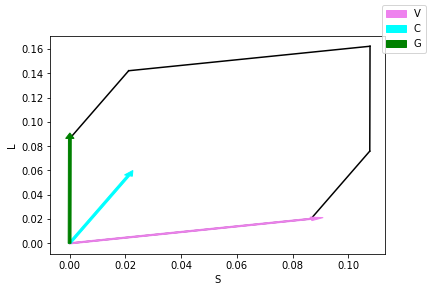

In [6]:
fig, axes = est.gamut_plot(colors=sources_colors)
fig.legend()

### Calculating capture

Here, we show how to calculate the capture of a photoreceptor or any sensory system that linearly integrates a stimulus according to its filtering properties.

The formula for calculating the absolute light-induced capture is as follows:
$$
Q = \int_{\lambda} S(\lambda)I(\lambda) d\lambda
$$

where $Q$ is the capture, $S(\lambda)$ is the sensory filter, and $I(\lambda)$ is the stimulus across wavelengths.

To calculate this capture, we use the `capture` method.

In [7]:
# random light distribution
rng = np.random.default_rng(10)
random_source = rng.random(wls.size) / wls.size * 0.5

Q = est.capture(random_source)

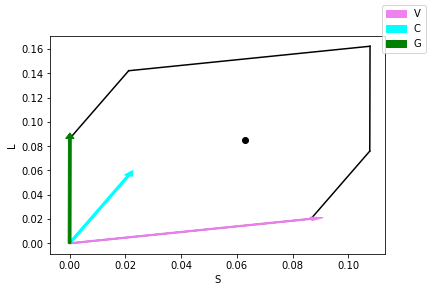

In [8]:
# location of capture
# relative should be set to False since the capture value is the absolute capture value and not the relative capture value (see later)
fig, axes = est.gamut_plot(np.atleast_2d(Q), colors=sources_colors, color='black', relative=False)
fig.legend()

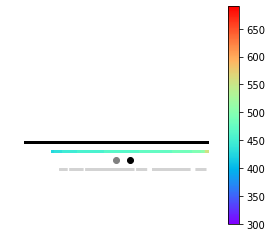

In [9]:
# point within the isoluminant plane
ax = est.simplex_plot(np.atleast_2d(Q), color='black')

### Forms of adaptation and the baseline

Photoreceptor usually adapt to the background light. Here, we go over three different methods to define the adaptional state of a receptor and show how to define a baseline capture for the receptor (i.e. a bias/offset).

The relative capture described the capture after incorporating the adaptational state and baseline:
$$
q = K (Q + baseline)
$$

For a photoreceptor, background adaptation is calculated by first calculating the capture of the background and then adding the baseline:
$$
q = (Q + baseline) / (Q_b + baseline)
$$

In [10]:
# register a baseline capture
est.register_baseline(1e-3)
print(est.baseline)
# setting K directly for each photoreceptor
est.register_adaptation(np.array([1, 1.5]))
print(est.K)
# setting K according to a background signal (important is to set the baseline beforehand)
background = norm.pdf(wls, loc=450, scale=100)  # flattish background
est.register_background_adaptation(background)
print(est.K)
# setting K according to intensities of our sources
source_bg = np.array([0.01, 0.015, 0.018])
est.register_system_adaptation(source_bg)
print(est.K)

[0.001]
[1.  1.5]
[2.93144946 2.5309583 ]
[77.8873311  37.14265137]


So now we have our adaptational state set to specific intensities of our LEDs. What would be the relative capture if we show our background light, while the photoreceptors are adapted to our LED background intensities:

In [11]:
est.relative_capture(background)

array([26.56956301, 14.67533122])

We can also calculate the relative capture (or capture) given specific LED intensities using the `system_relative_capture` or `system_capture` method:

[1. 1.]
[0.01183906 0.02592323]


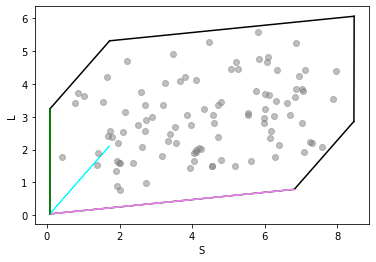

In [12]:
B = est.system_relative_capture(source_bg)
print(B)  # this should be one
print(est.system_capture(source_bg))  # this is the absolute light-induced capture for the background intensities

# let's sample various intensities and plot the captures in the gamut diagram
# since we bound our samples by our intensity bounds, all samples should be within the gamut
rng = np.random.default_rng(10)
X = rng.random((100, 3)) * 0.1  # within the bounds of our intensities
B = est.system_relative_capture(X)

fig, axes = est.gamut_plot(B, colors=sources_colors, color='gray', alpha=0.5)

## Analyzing and fitting many capture values

* Is a capture value within the gamut of the system?
* Sampling values within the hull/gamut of the system (and at a specific intensity/l1-norm)
* Finding the optimal LED intensities for a desired spectral distribution (or target capture values)

True
[False False  True  True False  True False  True  True  True]


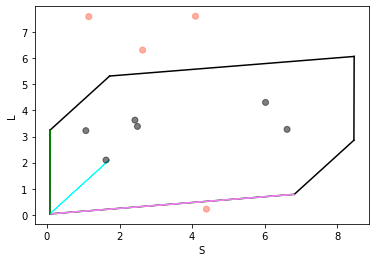

In [13]:
# testing if a capture value is within the hull/gamut of the stimulation system
print(est.in_hull(B).all())  # all previously sampled values should be within the hull

rng = np.random.default_rng(1)
Bnew = rng.random((10, 2)) * 8
inhull = est.in_hull(Bnew)
print(inhull)  # not all are within the hull
hull_colors = ['black' if x else 'tomato' for x in inhull]
fig, axes = est.gamut_plot(Bnew, colors=sources_colors, c=hull_colors, alpha=0.5)

### Sampling within the hull

Unlike previously where we sampled uniformly within LED space, we can also sample within the hull/gamut directly using the `sample_in_hull` method.
This can help reduce the number of gaps and clumps in capture space (lower discrepency).

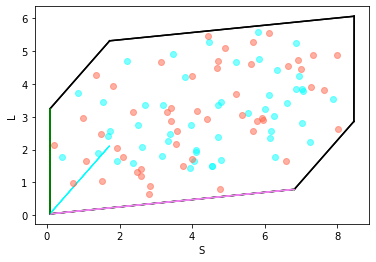

In [14]:
# sampling in LED space
rng = np.random.default_rng(10)
X = rng.random((50, 3)) * 0.1  # within the bounds of our intensities
B1 = est.system_relative_capture(X)

# using a QMC engine
B2 = est.sample_in_hull(50, seed=10, engine='Halton')

fig, axes = est.gamut_plot(B1, colors=sources_colors, c='cyan', alpha=0.5)
fig, axes = est.gamut_plot(B2, colors=sources_colors, c='tomato', alpha=0.5, axes=axes)

### Fitting target capture values

Next, we will show the basics of finding the optimal intensity vectors for our LEDs for given capture values. More detail into different fitting procedures can be found in the API reference and other tutorials. The basic method for fitting is the `fit` method.

In [16]:
# Fitting points sampled in hull
X, Bhat = est.fit(B2, verbose=1)

# all points can be fit perfectly
print(np.allclose(B2, Bhat))

Iterations: 100%|██████████| 50/50 [00:00<00:00, 567.43it/s]

True


[False False  True  True False  True False  True  True  True]


Iterations: 100%|██████████| 10/10 [00:00<00:00, 375.85it/s]


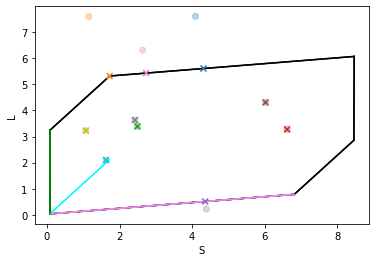

In [21]:
# Fitting with some points outside the hull
rng = np.random.default_rng(1)
Bnew = rng.random((10, 2)) * 8
inhull = est.in_hull(Bnew)
print(inhull)  # not all are within the hull
colors = sns.color_palette('tab10', len(Bnew))

# Fitting points
X, Bnewhat = est.fit(Bnew, verbose=1)

fig, axes = est.gamut_plot(Bnew, colors=sources_colors, c=colors, alpha=0.3)
fig, axes = est.gamut_plot(Bnewhat, colors=sources_colors, c=colors, marker='x', alpha=1, axes=axes)